In [1]:
import torch
from torchvision import datasets, transforms
import numpy as np
import pickle
import matplotlib.pyplot as plt
import random
import torch.optim as optim
import time
import torch.utils.data
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import pandas as pd
from models import *
import torch
import torch.nn as nn
import torch.nn.functional as F

c:\Users\Citylab\.conda\envs\torchenv2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load CIFAR 10 Data


In [2]:
#function to load a batch file and return a dictionary
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

#load dataset, combine batches, split, and visualize images
def load_and_prepare_data():
    #load and combine the training batches
    data_batches, label_batches = [], []
    for i in range(1, 6):
        batch = unpickle(f'data/KaggleData/cifar-10-python/cifar-10-batches-py/data_batch_{i}')
        data_batches.append(batch[b'data'])
        label_batches.append(batch[b'labels'])
    X, y = np.concatenate(data_batches), np.concatenate(label_batches)
    
    #split into training and validation sets (80-20 split)
    return train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = load_and_prepare_data()

#define transformations
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
transformations = {
    'train': transforms.Compose([
        transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
        transforms.RandomHorizontalFlip(), 
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(), 
        transforms.RandomApply([transforms.RandomErasing()], p=0.5),
        transforms.Normalize(*stats)]),
        
    'valid': transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(*stats)]),
        
    #normalization only for 'train_Default' scenario
    'normalization_only': transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(*stats)])
}

#adjusting the CIFAR10Dataset class initialization to accept 'data_mode'
class CIFAR10Dataset(Dataset):
    def __init__(self, data, labels, transform=None, data_mode='default'):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.data_mode = data_mode
        if data_mode == 'train_Enhanced':
            self.data = np.concatenate((self.data, self.data), axis=0)
            self.labels = np.concatenate((self.labels, self.labels), axis=0)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        if self.data_mode == 'train_Enhanced' and idx >= len(self.labels) // 2:
            transform = transformations['train']
        else:
            transform = self.transform
        image = self.data[idx % len(self.labels)].reshape(3, 32, 32).transpose(1, 2, 0)
        image = Image.fromarray(image.astype('uint8'), 'RGB')
        image = transform(image)
        return image, self.labels[idx % len(self.labels)]

#create datasets and DataLoader instances
datasets = {
    'train_Enhanced': CIFAR10Dataset(X_train, y_train, transform=transformations['normalization_only'], data_mode='train_Enhanced'),
    'valid': CIFAR10Dataset(X_val, y_val, transform=transformations['valid'])
}

#update loaders for each dataset
loaders = {
    'train_Enhanced': DataLoader(datasets['train_Enhanced'], batch_size=64, shuffle=True),
    'valid': DataLoader(datasets['valid'], batch_size=64, shuffle=False)
}

print('Amount of Train Data batches (Enhanced):', len(loaders['train_Enhanced']))
print('Amount of Valid Data batches:', len(loaders['valid']))

print('Amount of training images (Enhanced):', len(datasets['train_Enhanced']))
print('Amount of Validation images:', len(X_val))


Amount of Train Data batches (Enhanced): 1250
Amount of Valid Data batches: 157
Amount of training images (Enhanced): 80000
Amount of Validation images: 10000


In [3]:
first_batch_images, first_batch_labels = next(iter(loaders['train_Enhanced']))
print(f"First batch images shape: {first_batch_images.shape}")
print(f"First batch labels shape: {first_batch_labels.shape}")


First batch images shape: torch.Size([64, 3, 32, 32])
First batch labels shape: torch.Size([64])


Training Images:


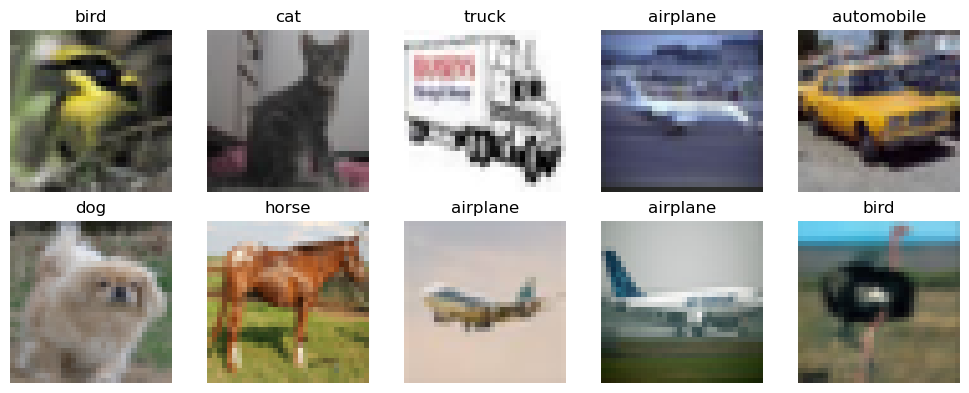

Validation Images:


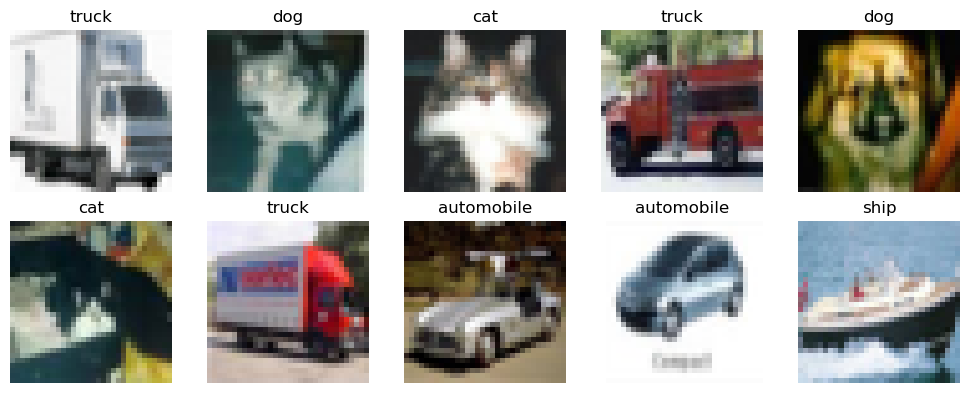

In [4]:
#visualize:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import ToPILImage
from random import sample

# Define a function to show images in a grid
def show_images(images, labels, classes, rows=2, cols=5, scale=2):
    fig, axes = plt.subplots(rows, cols, figsize=(scale*cols, scale*rows))
    axes = axes.flatten()
    for img, label, ax in zip(images, labels, axes):
        img = img.reshape(3, 32, 32).transpose(1, 2, 0)  #convert to HxWxC format
        if np.max(img) > 1:  #assume the image is in the range [0, 255]
            img = img / 255.0
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(classes[label])
    plt.tight_layout()
    plt.show()

# Classes in CIFAR-10
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

#randomly select 10 images and their labels from training set
indices_train = sample(range(len(X_train)), 10)
images_train = X_train[indices_train]
labels_train = y_train[indices_train]

#randomly select 10 images and their labels from validation set
indices_val = sample(range(len(X_val)), 10)
images_val = X_val[indices_val]
labels_val = y_val[indices_val]

#display training images
print("Training Images:")
show_images(images_train, labels_train, classes)

#display validation images
print("Validation Images:")
show_images(images_val, labels_val, classes)



In [5]:
#define model from models.py, move it to GPU.

def Resnet3_443Exp():
    return ResNet3(BasicBlock, [4,4,3])

model = Resnet3_443Exp()

total_paramsResnet3_443 = sum(p.numel() for p in model.parameters())
print(f"Total parameters modelResnet3_443: {total_paramsResnet3_443}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))

model.to(device)

Total parameters modelResnet3_443: 4697162
NVIDIA GeForce RTX 4070


ResNet3(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

# Training

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt
import time

def train_and_evaluate_model(model, model_name, loaders, device, weight_decay, num_epochs=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=weight_decay)
    scheduler = ExponentialLR(optimizer, gamma=0.98)

    train_loss_history, valid_loss_history, valid_accuracy_history, train_accuracy_history = [], [], [], []
    best_accuracy = 0.0
    start_time = time.time()

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, total_train_loss, total_correct_train, num_batches, num_train_examples = 0.0, 0.0, 0, 0, 0
        for i, (inputs, labels) in enumerate(loaders["train_Enhanced"]):
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(),0.1)

            optimizer.step()

            running_loss += loss.item()
            total_train_loss += loss.item() * inputs.size(0)
            num_batches += 1

            _, predicted = torch.max(outputs.data, 1)
            total_correct_train += (predicted == labels).sum().item()
            num_train_examples += labels.size(0)

            if (i + 1) % 100 == 0 or i == len(loaders["train_Enhanced"]) - 1:
                print(f"{model_name}, train_Enhanced - Epoch: {epoch} [{(i + 1) * len(inputs)}/{len(loaders['train_Enhanced'].dataset)} "
                      f"({100. * (i + 1) / len(loaders['train_Enhanced']):.0f}%)], Weight Decay: {weight_decay},  Loss: {running_loss / num_batches:.4f}")

        avg_train_loss = total_train_loss / num_train_examples  
        train_loss_history.append(avg_train_loss)

        train_accuracy = 100. * total_correct_train / num_train_examples
        train_accuracy_history.append(train_accuracy)

        model.eval()
        total_valid_loss, total_correct_valid, num_valid_batches = 0.0, 0, 0
        for inputs, labels in loaders['valid']:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_valid_loss += loss.item() * inputs.size(0) 
            _, predicted = torch.max(outputs.data, 1)
            total_correct_valid += (predicted == labels).sum().item()
            num_valid_batches += 1

        avg_valid_loss = total_valid_loss / len(loaders['valid'].dataset)  
        valid_loss_history.append(avg_valid_loss)

        valid_accuracy = 100. * total_correct_valid / len(loaders['valid'].dataset)
        valid_accuracy_history.append(valid_accuracy)

        print(f"End of Epoch: {epoch}, Avg. Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Avg. Valid Loss: {avg_valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%")

        if valid_accuracy > best_accuracy:
            best_accuracy = valid_accuracy
            model_path = f'{model_name}_Final_best_model_secondRun.pth'
            torch.save(model.state_dict(), model_path)
            print(f"New best model saved: {model_path}")

        scheduler.step()

    execution_time = time.time() - start_time
    print(f"Training completed. Total execution time: {execution_time:.2f} seconds")

    return train_loss_history, valid_loss_history, valid_accuracy_history, train_accuracy_history


Training with weight decay: 1e-05
Resnet3_443_Exp, train_Enhanced - Epoch: 1 [6400/80000 (8%)], Weight Decay: 1e-05,  Loss: 1.9453
Resnet3_443_Exp, train_Enhanced - Epoch: 1 [12800/80000 (16%)], Weight Decay: 1e-05,  Loss: 1.8226
Resnet3_443_Exp, train_Enhanced - Epoch: 1 [19200/80000 (24%)], Weight Decay: 1e-05,  Loss: 1.7382
Resnet3_443_Exp, train_Enhanced - Epoch: 1 [25600/80000 (32%)], Weight Decay: 1e-05,  Loss: 1.6720
Resnet3_443_Exp, train_Enhanced - Epoch: 1 [32000/80000 (40%)], Weight Decay: 1e-05,  Loss: 1.6146
Resnet3_443_Exp, train_Enhanced - Epoch: 1 [38400/80000 (48%)], Weight Decay: 1e-05,  Loss: 1.5680
Resnet3_443_Exp, train_Enhanced - Epoch: 1 [44800/80000 (56%)], Weight Decay: 1e-05,  Loss: 1.5258
Resnet3_443_Exp, train_Enhanced - Epoch: 1 [51200/80000 (64%)], Weight Decay: 1e-05,  Loss: 1.4888
Resnet3_443_Exp, train_Enhanced - Epoch: 1 [57600/80000 (72%)], Weight Decay: 1e-05,  Loss: 1.4564
Resnet3_443_Exp, train_Enhanced - Epoch: 1 [64000/80000 (80%)], Weight Decay:

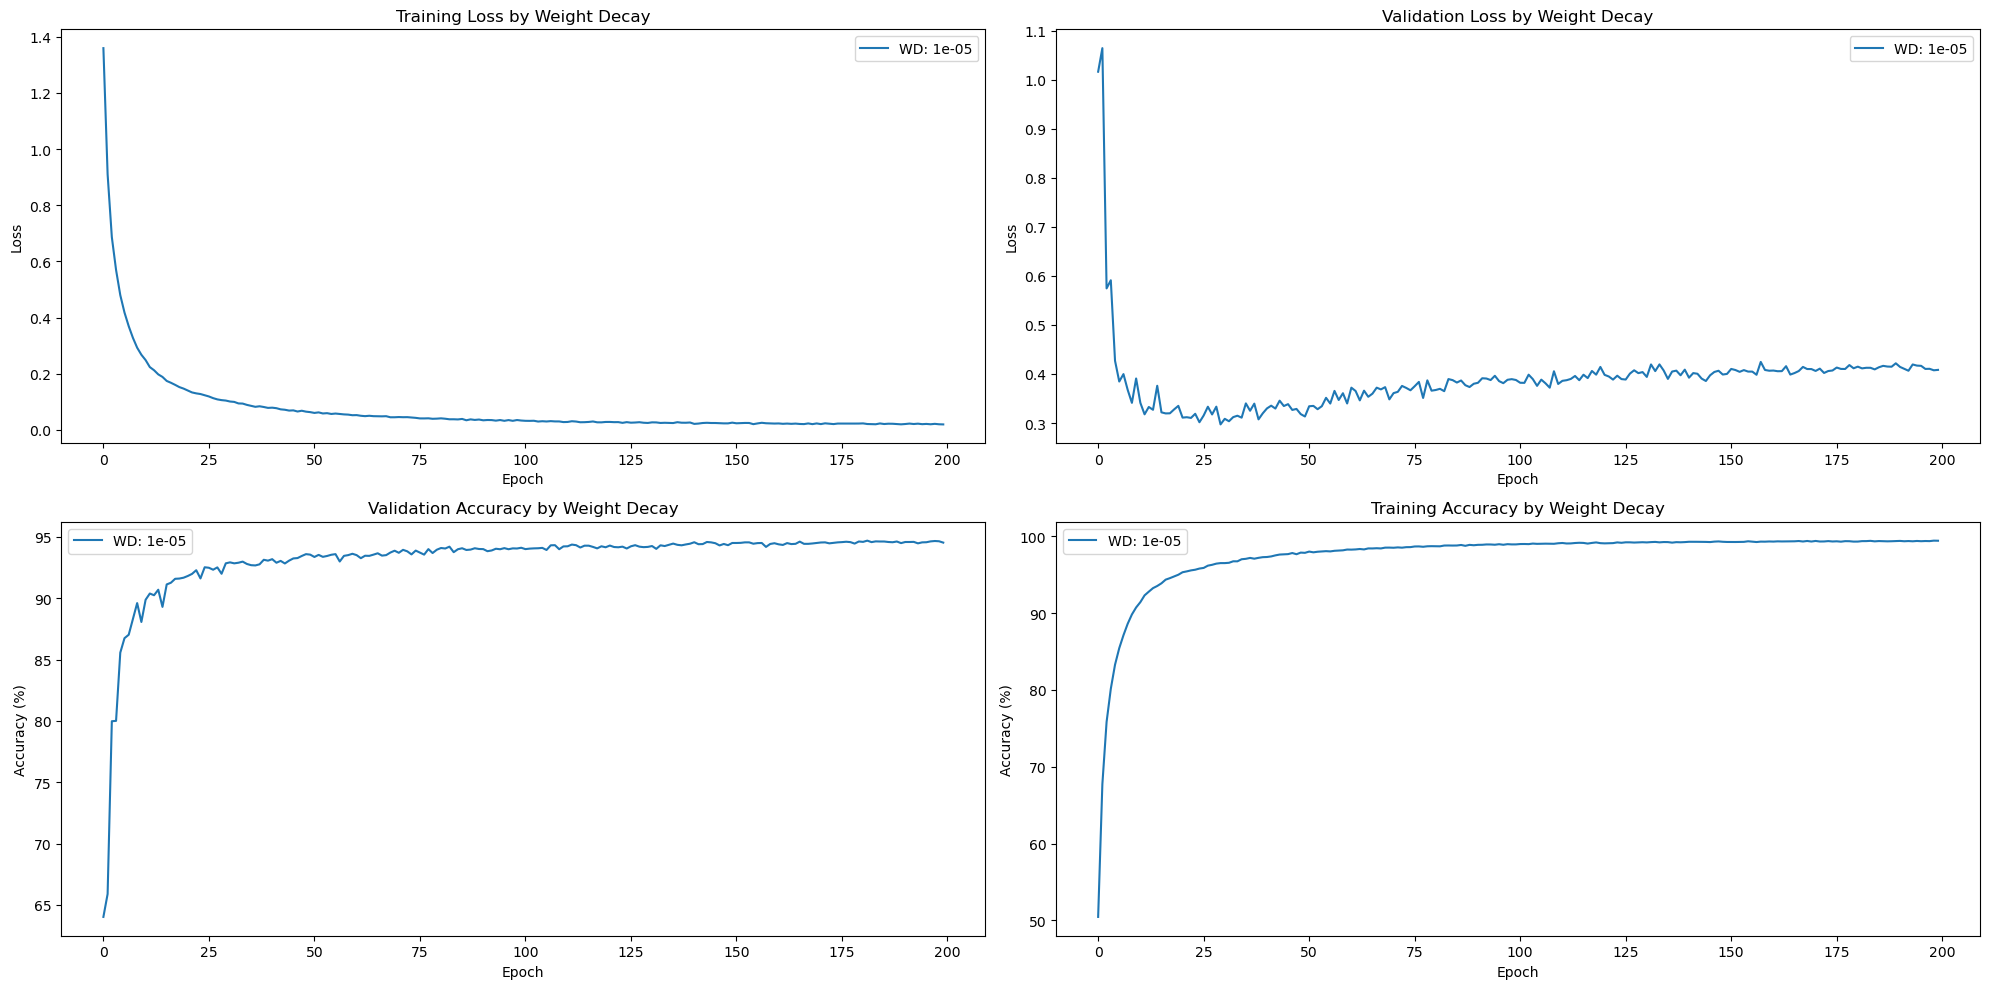

In [12]:
import torch
from torch.optim import AdamW
import matplotlib.pyplot as plt

weight_decays = [0.00001]
num_epochs = 200

all_metrics_weight_decay = {
    wd: {'train_losses': [], 'valid_losses': [], 'valid_accuracies': [], 'train_accuracies': []}
    for wd in weight_decays
}

for weight_decay in weight_decays:
    print(f"Training with weight decay: {weight_decay}")
    metrics = train_and_evaluate_model(model, "Resnet3_443_Exp", loaders, device, weight_decay, num_epochs)
    
    all_metrics_weight_decay[weight_decay]['train_losses'], \
    all_metrics_weight_decay[weight_decay]['valid_losses'], \
    all_metrics_weight_decay[weight_decay]['valid_accuracies'], \
    all_metrics_weight_decay[weight_decay]['train_accuracies'] = metrics

# Plotting
plt.figure(figsize=(20, 10))

# Training Loss
plt.subplot(2, 2, 1)
for wd, metrics in all_metrics_weight_decay.items():
    plt.plot(metrics['train_losses'], label=f'WD: {wd}')
plt.title('Training Loss by Weight Decay')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Validation Loss
plt.subplot(2, 2, 2)
for wd, metrics in all_metrics_weight_decay.items():
    plt.plot(metrics['valid_losses'], label=f'WD: {wd}')
plt.title('Validation Loss by Weight Decay')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Validation Accuracya
plt.subplot(2, 2, 3)
for wd, metrics in all_metrics_weight_decay.items():
    plt.plot(metrics['valid_accuracies'], label=f'WD: {wd}')
plt.title('Validation Accuracy by Weight Decay')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Training Accuracy
plt.subplot(2, 2, 4)
for wd, metrics in all_metrics_weight_decay.items():
    plt.plot(metrics['train_accuracies'], label=f'WD: {wd}')
plt.title('Training Accuracy by Weight Decay')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [6]:


model_path = 'Resnet3_443_Exp_Final_best_model_secondRun.pth'
model.load_state_dict(torch.load(model_path))
model.eval()


ResNet3(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

# Testing

test images:


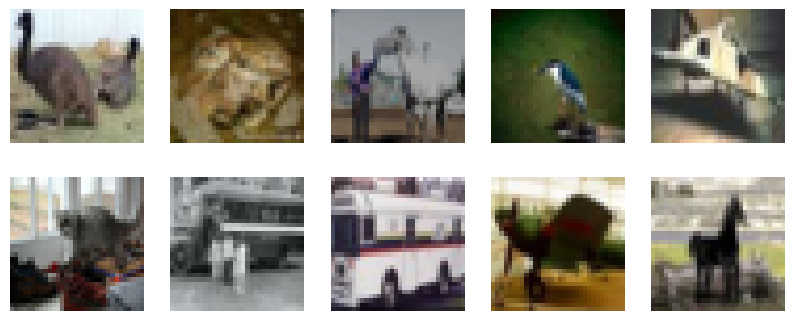

In [7]:
#Visualize Testdata
import numpy as np
import matplotlib.pyplot as plt

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

test_data_dict = unpickle('./data/cifar_test_nolabels.pkl')
test_images = test_data_dict[b'data']
test_images = test_images.reshape(-1, 3, 32, 32)

def show_original_random_images(images, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    indices = np.random.choice(len(images), rows*cols, replace=False)  
    for i, ax in enumerate(axes.flat):
        img = images[indices[i]].transpose(1, 2, 0)
        ax.imshow(img.astype('uint8'))
        ax.axis('off')
    plt.show()

print('test images:')
show_original_random_images(test_images, rows=2, cols=5)


In [8]:
model_path

'Resnet3_443_Exp_Final_best_model_secondRun.pth'

In [9]:

test_images = torch.from_numpy(test_images).float()

if test_images.max() > 1.0:
    test_images /= 255.0

test_images = test_images.permute(0, 1, 2, 3)

normalize = transforms.Normalize(*stats) 

normalized_images = torch.stack([normalize(img) for img in test_images])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.load_state_dict(torch.load(model_path))


model.to(device)

normalized_images = normalized_images.to(device)

model.eval() 

predictions = []
with torch.no_grad():  
    for img in normalized_images:
        img = img.unsqueeze(0).to(device)  
        output = model(img)  
        pred = output.argmax(dim=1)  
        predictions.append(pred.item())
print(len(predictions))

submission_df = pd.DataFrame({
    'ID': list(range(len(predictions))),
    'Labels': predictions
})

submission_csv_path = 'submission.csv'
submission_df.to_csv(submission_csv_path, index=False)

submission_csv_path

10000


'submissionV2.csv'